# Image generation using GAN

## Imports

In [63]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras
import cv2
import os
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from IPython import display
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Rescaling, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint

## Memory growth for GPU

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

## Helper Functions

In [27]:
def plot_results(images, n_cols=None, unnorm=True):
    '''visualizes fake images'''
    display.clear_output(wait=False)

    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1


    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))

    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        imageorg = image
        if unnorm:
          imageorg = (image +1) * 0.5
        plt.imshow(imageorg)
        plt.axis("off")

In [28]:
def smooth_positive(y):
  return y -0.2 + (np.random.random(y.shape) * 0.4)

def smooth_negative(y):
  return y + np.random.random(y.shape) * 0.3

In [29]:
def generate_real_samples(dataset, n_samples):
  i = np.randint(0, dataset.shape[0], n_samples)
  X = dataset[i]

## Load Images and augment data

Path to the dataset used and setting the image size and batch size:

In [30]:
img_height, img_width = 64, 64
batch_size = 32

train_datagen  = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1.0 / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest",
    data_format="channels_last",
    brightness_range=[0.6, 1.1],
)

validation_datagen = ImageDataGenerator(rescale=1./255)

In [31]:
img_dir = "./../data/images/classes"  # Enter Directory of all images
train_generator = train_datagen.flow_from_directory(
    img_dir,          # Directory path to the training dataset
    target_size=(32, 32),   # Resize images to 150x150 pixels
    batch_size=128,            # Number of images to yield per batch
    class_mode='categorical'  # Use 'categorical' for multi-class classification
)

Found 13 images belonging to 13 classes.


In [32]:
target_num_images = 2000
X = np.zeros((target_num_images, 32, 32, 3), dtype=np.float32)

# Initialize a counter for the total number of images saved
num_images_saved = 0

# Loop through the batches of images generated by the train_generator
while num_images_saved < target_num_images:
    # Get the next batch of images and labels
    images, labels = next(train_generator)
    
    # Calculate how many images we need to save from this batch
    num_images_to_save = min(images.shape[0], target_num_images - num_images_saved)
    
    # Save the images into the numpy array
    X[num_images_saved:num_images_saved + num_images_to_save] = images[:num_images_to_save]
    
    # Increment the counter
    num_images_saved += num_images_to_save

print(f"{num_images_saved} images have been generated and stored in the numpy array X")

2000 images have been generated and stored in the numpy array X


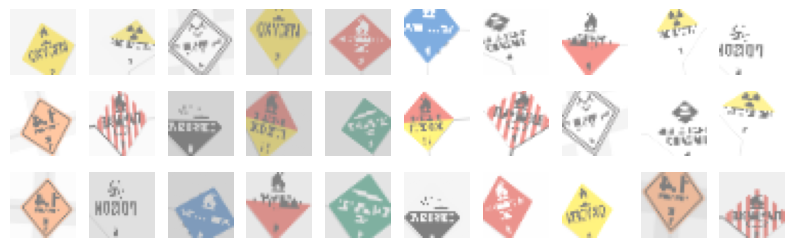

In [33]:
plot_results(X[50:80], 10)

In [34]:
# normalize pixel values
X = X.astype(np.float32)

# #Rescale
# #X_train = X_train.reshape(-1, 28, 28, 3) * 2. - 1.
# X = (X -127.5) / 127.5

BATCH_SIZE = 128

# create batches of tensors to be fed into the model
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset = dataset.shuffle(500)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

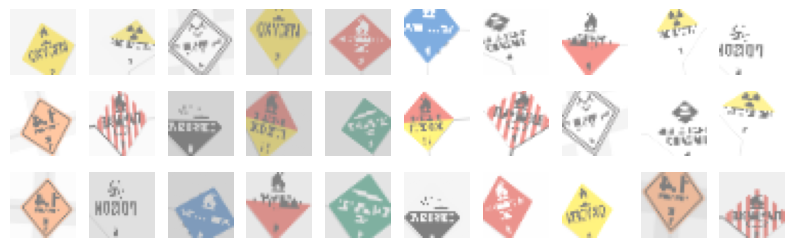

In [35]:
plot_results(X[50:80], 10)

# GAN network

## Build the Generator

In [36]:
noise_input = 100
generator = keras.models.Sequential([
    keras.layers.Dense(4 * 4 * 128, input_shape=[noise_input],
                       activation=keras.layers.LeakyReLU(negative_slope=0.2)),
    keras.layers.Reshape([4, 4, 128]),
    keras.layers.BatchNormalization(),

    #First UpSample doubling the size to 32x32
    keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME",
                                 activation=keras.layers.LeakyReLU(negative_slope=0.2)),
    keras.layers.BatchNormalization(),

    #Second UpSample doubling the size to 64x64
    keras.layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="SAME",
                                 activation=keras.layers.LeakyReLU(negative_slope=0.2)),
    keras.layers.BatchNormalization(),

    #Last UpSample doubling the size to 128x128
    keras.layers.Conv2DTranspose(3, kernel_size=4, strides=2, padding="SAME",
                                 activation='tanh'),
                                 ])

c:\Users\Ana\miniconda3\envs\hazmat-env\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [37]:
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │       206,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 8, 8, 128)      │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 16, 16, 128)    │       262,272 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 32, 32, 3)      │         6,147 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 739,075 (2.82 MB)

 Trainable params: 738,307 (2.82 MB)

 Non-trainable params: 768 (3.00 KB)

## Build the Discriminator

In [38]:
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[32, 32, 3]),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),

    keras.layers.Conv2D(64, kernel_size=3, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),

    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])

c:\Users\Ana\miniconda3\envs\hazmat-env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [39]:
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         1,025 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,745 (311.50 KB)

 Trainable params: 79,745 (311.50 KB)

 Non-trainable params: 0 (0.00 B)

## Combine the Generator and the Discriminator into One Model to Create the GAN Network

In [40]:
gan = keras.models.Sequential([generator, discriminator])

In [17]:
optimizer_disc = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
optimizer_gen = keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
discriminator.compile(loss='binary_crossentropy', optimizer=optimizer_disc, metrics=['accuracy'])

discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer=optimizer_gen)

In [41]:
gan.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │       739,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │        79,745 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 818,820 (3.12 MB)

 Trainable params: 818,052 (3.12 MB)

 Non-trainable params: 768 (3.00 KB)

## Training Loop

In [42]:

def train_gan(gan, dataset, random_normal_dimensions, n_epochs=30):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """
    generator, discriminator = gan.layers
    noise = tf.random.normal(shape=[128, random_normal_dimensions])
    fake_images = generator(noise)

    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # use the noise to generate fake images
            fake_images = generator(noise)
            
            # create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)

            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_zeros = smooth_negative(np.zeros((batch_size, 1)))
            discriminator_ones = smooth_positive(np.ones((batch_size, 1)))
            discriminator_labels= tf.convert_to_tensor(np.concatenate((discriminator_zeros, discriminator_ones)))
            #discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

            # ensure that the discriminator is trainable
            discriminator.trainable = True

            # use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)

            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # label all generated images to be "real"
            generator_ones = smooth_positive(np.ones((batch_size, 1)))
            generator_labels = tf.convert_to_tensor(generator_ones)
            #generator_labels = tf.constant([[1.]] * batch_size)

            # freeze the discriminator
            discriminator.trainable = False

            # train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)

        # plot the fake images used to train the discriminator
        plot_results(fake_images[0:30], 10)
        plt.show()

In [43]:
#Sample of smoothed labels
batch_size=5

#discriminator_zeros = np.zeros((batch_size, 1)) #+ np.ones(batch_size)
discriminator_zeros = smooth_negative(np.zeros((batch_size, 1)))
discriminator_ones = smooth_positive(np.ones((batch_size, 1)))
discriminator_labels= tf.convert_to_tensor(np.concatenate((discriminator_zeros, discriminator_ones)))


In [44]:
discriminator_labels

<tf.Tensor: shape=(10, 1), dtype=float64, numpy=
array([[0.22351551],
       [0.18526633],
       [0.03839848],
       [0.07498222],
       [0.17492829],
       [1.14553783],
       [0.93932832],
       [1.11770112],
       [1.01236597],
       [1.05981685]])>

In [45]:
discriminator_labels = tf.constant([[0]]*batch_size + [[1]]*batch_size)
discriminator_labels

<tf.Tensor: shape=(10, 1), dtype=int32, numpy=
array([[0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1]])>

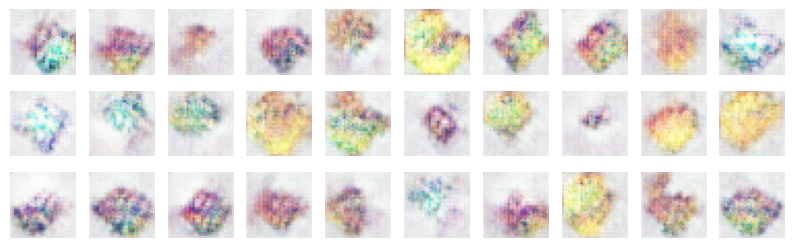

In [24]:
train_gan(gan, dataset, noise_input, 200)

## Test Out the Generator

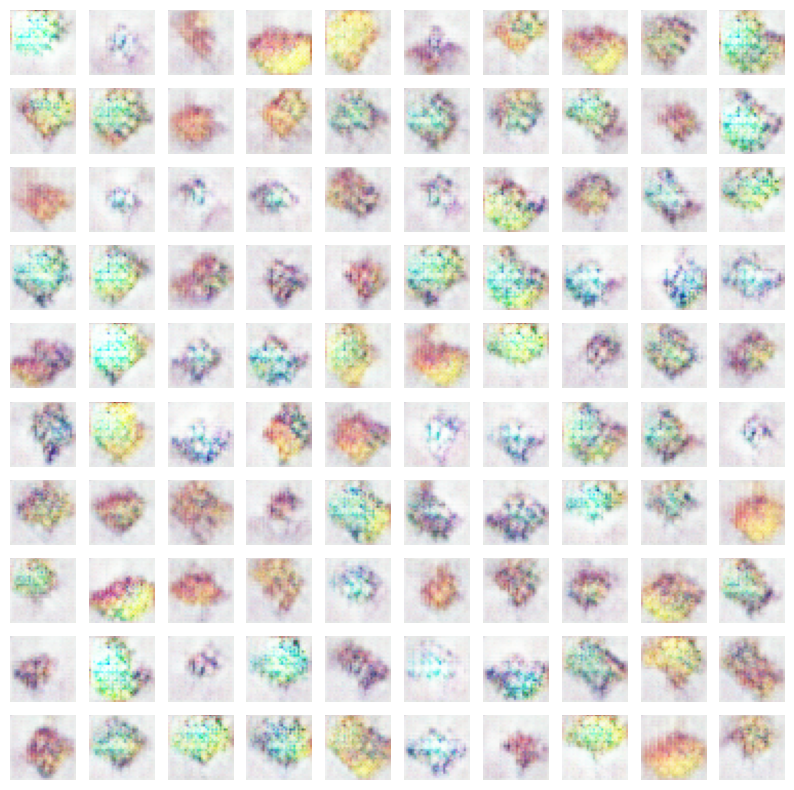

In [25]:
noise = tf.random.normal(shape=[128, noise_input])
fake_images = generator(noise)
plot_results(fake_images[0:100],10)

## Save the Trained Models

In [27]:
from keras.models import save_model

save_model(generator, './../models/generator.keras')  # Save generator in native Keras format
save_model(discriminator, './../models/discriminator.keras')  # Save discriminator in native Keras format
save_model(gan, './../models/gan.keras')  # Save gan in native Keras format

## Reload previously trained models

In [67]:
custom_objects = {'LeakyReLU': LeakyReLU}

generator_model = load_model('./../models/generator.keras', custom_objects=custom_objects)
discriminator_model = load_model('./../models/discriminator.keras', custom_objects=custom_objects)


## Review Performance